In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import xarray as xr
import glob
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pandas as pd
import cmocean.cm as cmo

In [2]:
# get dataset 

nao = np.load("/work/uo1075/u241321/data/eemd_t310_assi_Norwegian.npy")
NAO = nao[2,:] # remove non-linear trend and standardize 
y = NAO

data_x = xr.open_dataset('/work/uo1075/u241321/data/uas_1969-2019_assi_dt.nc', decode_times=False)  # unit: m/s
data_y = xr.open_dataset('/work/uo1075/u241321/data/vas_1969-2019_assi_dt.nc', decode_times=False)

var_x = np.mean(data_x['__xarray_dataarray_variable__'], axis=1) 
var_y = np.mean(data_y['__xarray_dataarray_variable__'], axis=1) 


In [3]:
# regression onto x and y transport respectively, then calculate manitude with direction

field_x = var_x.stack(spatial=('lat','lon')).dropna(dim="spatial") #time,space

nn = 6 # number of regression year


from sklearn.linear_model import LinearRegression
def regression(x,y):

    coef = LinearRegression(fit_intercept=True).fit(x.reshape(-1, 1), y.values.reshape(-1, 1)).coef_
    

    return coef

# regression, center on 4-47, 44 year (start from 0)

coe_x = np.zeros((nn, field_x.shape[1]))

for m in range(0,field_x.shape[1],1):
        coe_x[0,m] = regression(y[5:49], field_x[0:44,m])
        coe_x[1,m] = regression(y[5:49], field_x[1:45,m])
        coe_x[2,m] = regression(y[5:49], field_x[2:46,m])
        coe_x[3,m] = regression(y[5:49], field_x[3:47,m])
        coe_x[4,m] = regression(y[5:49], field_x[4:48,m])
        coe_x[5,m] = regression(y[5:49], field_x[5:49,m])
       


In [4]:
coe_x = xr.DataArray(coe_x,  
                    dims=['mode','spatial'],
                    coords=dict(
                        spatial=field_x.spatial,
                         mode=np.arange(1,nn+1,1))
                    , )
# field = var.stack(spatial=('lat','lon')).dropna(dim="spatial") #time,space
spatial = field_x .coords["spatial"]
mode = coe_x .coords["mode"]
reg_x = xr.DataArray(coe_x, dims = ["mode","spatial"], coords = {"mode":mode,"spatial":spatial}).unstack()  


In [5]:
field_y = var_y.stack(spatial=('lat','lon')).dropna(dim="spatial") #time,space
coe_y = np.zeros((nn, field_y.shape[1]))

for m in range(0,field_y.shape[1],1):
        coe_y[0,m] = regression(y[5:49], field_y[0:44,m])
        coe_y[1,m] = regression(y[5:49], field_y[1:45,m])
        coe_y[2,m] = regression(y[5:49], field_y[2:46,m])
        coe_y[3,m] = regression(y[5:49], field_y[3:47,m])
        coe_y[4,m] = regression(y[5:49], field_y[4:48,m])
        coe_y[5,m] = regression(y[5:49], field_y[5:49,m])


In [6]:
coe_y = xr.DataArray(coe_y,  
                    dims=['mode','spatial'],
                    coords=dict(
                        spatial=field_y.spatial,
                         mode=np.arange(1,nn+1,1))
                    , )

spatial_y = field_y .coords["spatial"]
reg_y = xr.DataArray(coe_y, dims = ["mode","spatial"], coords = {"mode":mode,"spatial":spatial_y}).unstack()        
lon = reg_x.lon
lat = reg_x.lat

In [7]:
reg_x.to_netcdf("/work/uo1075/u241321/data/reg_windx_T_c2_44.nc")
reg_y.to_netcdf("/work/uo1075/u241321/data/reg_windy_T_c2_44.nc")

NameError: name 'ssh' is not defined

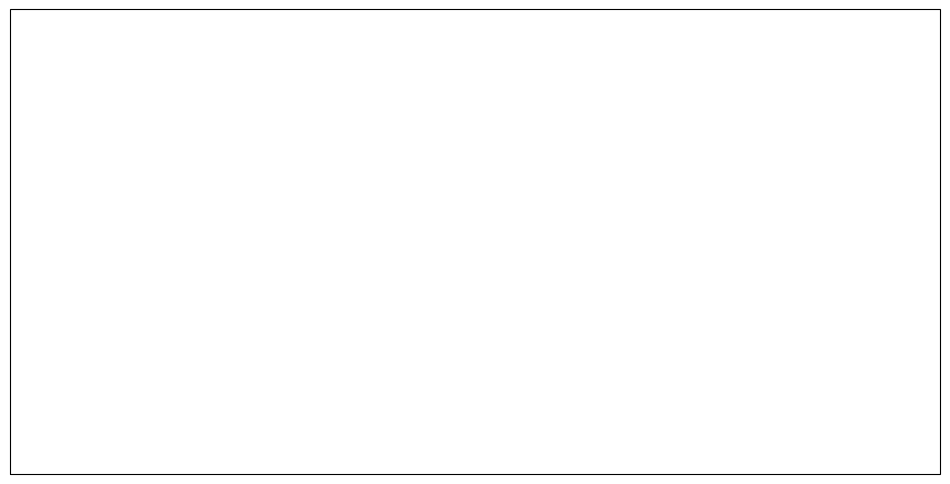

In [8]:


# cc = corr
fig = plt.figure(figsize=(12,8));
ax = plt.axes(projection=ccrs.PlateCarree())

p1 = ssh[0].plot.contourf(ax=ax, x='lon', y='lat',levels = np.arange(-8, 9, 1), 
                              cmap='RdBu_r',
                              extend = 'both', add_colorbar=False, add_labels=False)

p = plt.quiver( lon[::4], lat[::4], reg_x [0,::4,::4], reg_y[0,::4,::4], scale = 10, scale_units = 'inches')  # ,
# scale: Scales the length of the arrow inversely..Number of data units per arrow length unit, e.g., m/s per plot width; a smaller scale parameter makes the arrow longer.
# scale_units: If the scale kwarg is None, the arrow length unit. Default is None.
# e.g. scale_units is 'inches', scale is 2.0, and (u, v) = (1, 0), then the vector will be 0.5 inches long.

#ax.coastlines()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                                              edgecolor='0.3',
                                              facecolor='none'))

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlines = True
gl.ylines = True
ax.set_extent([-80,60,30,90])
gl.xlocator = mticker.FixedLocator(np.arange(-80,90,10))
gl.ylocator = mticker.FixedLocator(np.arange(50,90,10)) #([30,60],180)


gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 11, 'color': 'k','rotation':0}
gl.ylabel_style = {'size':11,'rotation':0}
plt.title('-1 yr', y=1, size = '19', loc = 'left', pad = 7)
cax = fig.add_axes([0.216, 0.12, 0.6, 0.03])
cb = plt.colorbar(p1, cax=cax, orientation='horizontal')



# cbar = plt.colorbar(p, orientation='vertical', shrink=0.8, pad = 0.1)
# cbar.set_label(' ', size= 15)
ax.set_title(' ',size = '15', pad = 30)

In [ ]:


# cc = corr
fig = plt.figure(figsize=(12,8));
ax = plt.axes(projection=ccrs.PlateCarree())

p1 = ssh[1].plot.contourf(ax=ax, x='lon', y='lat',levels = np.arange(-8, 9, 1), 
                              cmap='RdBu_r',
                              extend = 'both', add_colorbar=False, add_labels=False)

p = plt.quiver( lon[::4], lat[::4], reg_x [1,::4,::4], reg_y[1,::4,::4], scale = 10, scale_units = 'inches')  # ,
# scale: Scales the length of the arrow inversely..Number of data units per arrow length unit, e.g., m/s per plot width; a smaller scale parameter makes the arrow longer.
# scale_units: If the scale kwarg is None, the arrow length unit. Default is None.
# e.g. scale_units is 'inches', scale is 2.0, and (u, v) = (1, 0), then the vector will be 0.5 inches long.

#ax.coastlines()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                                              edgecolor='0.3',
                                              facecolor='none'))

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlines = True
gl.ylines = True
ax.set_extent([-80,60,30,90])
gl.xlocator = mticker.FixedLocator(np.arange(-80,90,10))
gl.ylocator = mticker.FixedLocator(np.arange(50,90,10)) #([30,60],180)


gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 11, 'color': 'k','rotation':0}
gl.ylabel_style = {'size':11,'rotation':0}
plt.title('0 yr', y=1, size = '19', loc = 'left', pad = 7)
cax = fig.add_axes([0.216, 0.12, 0.6, 0.03])
cb = plt.colorbar(p1, cax=cax, orientation='horizontal')



# cbar = plt.colorbar(p, orientation='vertical', shrink=0.8, pad = 0.1)
# cbar.set_label(' ', size= 15)
ax.set_title(' ',size = '15', pad = 30)

In [ ]:


# cc = corr
fig = plt.figure(figsize=(12,8));
ax = plt.axes(projection=ccrs.PlateCarree())

p1 = ssh[2].plot.contourf(ax=ax, x='lon', y='lat',levels = np.arange(-8, 9, 1), 
                              cmap='RdBu_r',
                              extend = 'both', add_colorbar=False, add_labels=False)

p = plt.quiver( lon[::4], lat[::4], reg_x [2,::4,::4], reg_y[2,::4,::4], scale = 10, scale_units = 'inches')  # ,
# scale: Scales the length of the arrow inversely..Number of data units per arrow length unit, e.g., m/s per plot width; a smaller scale parameter makes the arrow longer.
# scale_units: If the scale kwarg is None, the arrow length unit. Default is None.
# e.g. scale_units is 'inches', scale is 2.0, and (u, v) = (1, 0), then the vector will be 0.5 inches long.

#ax.coastlines()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                                              edgecolor='0.3',
                                              facecolor='none'))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlines = True
gl.ylines = True
ax.set_extent([-80,60,30,90])
gl.xlocator = mticker.FixedLocator(np.arange(-80,90,10))
gl.ylocator = mticker.FixedLocator(np.arange(50,90,10)) #([30,60],180)


gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 11, 'color': 'k','rotation':0}
gl.ylabel_style = {'size':11,'rotation':0}
plt.title('1 yr', y=1, size = '19', loc = 'left', pad = 7)
cax = fig.add_axes([0.216, 0.12, 0.6, 0.03])
cb = plt.colorbar(p1, cax=cax, orientation='horizontal')



# cbar = plt.colorbar(p, orientation='vertical', shrink=0.8, pad = 0.1)
# cbar.set_label(' ', size= 15)
ax.set_title(' ',size = '15', pad = 30)